In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dataclasses import dataclass

import emcee
from scipy.optimize import minimize
from scipy.stats import t, norm

In [5]:
from surp import subgiants
import surp
import vice
from surp import gce_math as gcem
import arya

import sys
sys.path.append("../..")


In [6]:
from singlezone import run_singlezone

In [7]:
def calc_model(**params):
    sz, h = run_singlezone(**params)
    
    return h.O_FE, h.C_O, h.sfr

In [8]:
def plot_sz(label="", **kwargs,):
    x, y, w = calc_model(**kwargs)
    plt.scatter(x, y, s=w, label=label)
    plt.xlabel("[Mg/Fe]")
    plt.ylabel("[C/Mg]")
    arya.Legend(loc=-1, color_only=True)

# Simple modeling

## AGB Yield properties

In [11]:
params = surp.YieldParams.from_file("../models/fiducial/yield_params.toml")

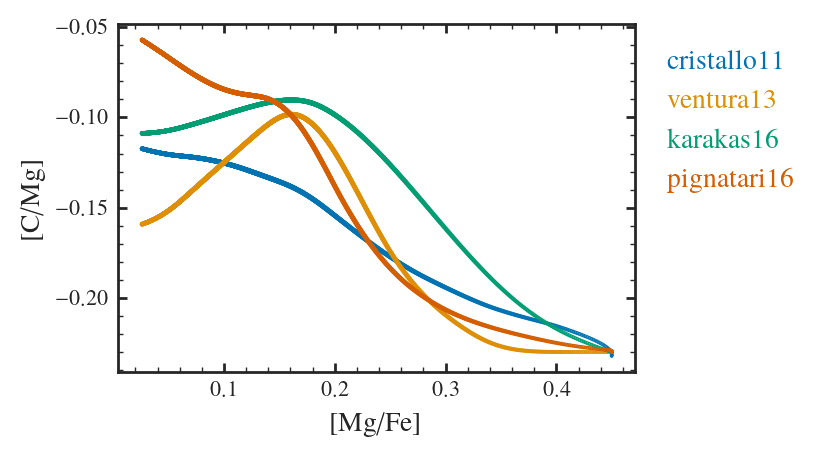

In [12]:
for model in surp.AGB_MODELS:
    surp.set_yields(params, Y_c_agb=model, alpha_c_agb=1, verbose=False)
    plot_sz(label=model)

In [22]:
def set_ana_yields(**kwargs):
    surp.set_yields(Y_c_agb="A", kwargs_c_agb=kwargs, verbose=False)

In [20]:
def set_yields(**kwargs):
    surp.set_yields(verbose=false, **kwargs)

yields set to Magg et al. 2022 abundances
Yield settings
X        Z_solar    CC                             agb                            SN Ia                          

c        3.39e-03   3.69e-03 MH^2 + 1.96e-03 MH +  1.45 × cristallo11             0.00e+00                       
                    2.20e-03                                                                                     

n        1.04e-03   5.00e-04                       5.02e-04 M Z/Z0                0                              

o        7.33e-03   7.13e-03                       0                              0                              

mg       6.71e-04   6.52e-04                       0                              0                              

fe       1.37e-03   4.73e-04                       0                              7.70e-04                       



yields set to Magg et al. 2022 abundances
Yield settings
X        Z_solar    CC                             agb                          

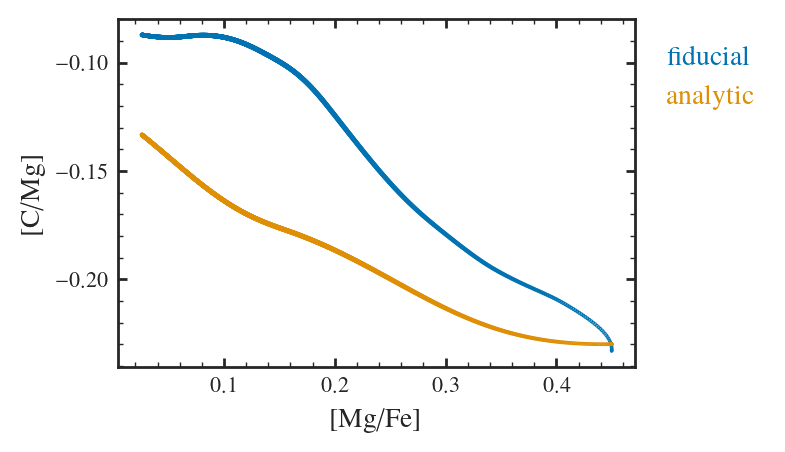

In [19]:
set_yields()
plot_sz(label="fiducial")
set_ana_yields(zeta=0, t_D=0.2)
plot_sz(label="analytic")

In [23]:
Y0 = 0.002

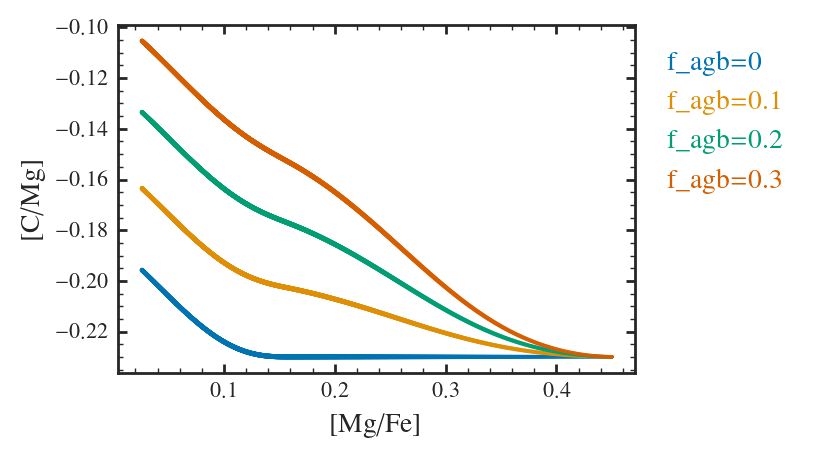

In [24]:
for model in [0, 0.1, 0.2, 0.3]:
    set_ana_yields(zeta=0, y0 = Y0 * model)
    plot_sz(label=f"f_agb={model}")

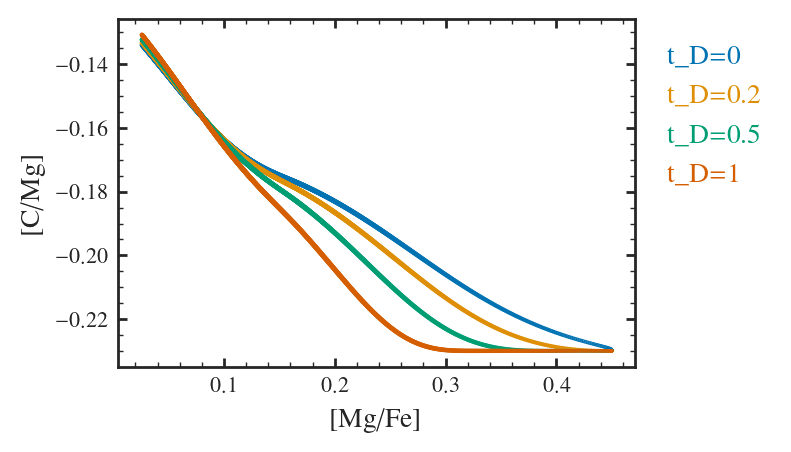

In [26]:
for model in [0, 0.2, 0.5, 1]:
    set_ana_yields(zeta=0, t_D=model)
    plot_sz(label=f"t_D={model}")

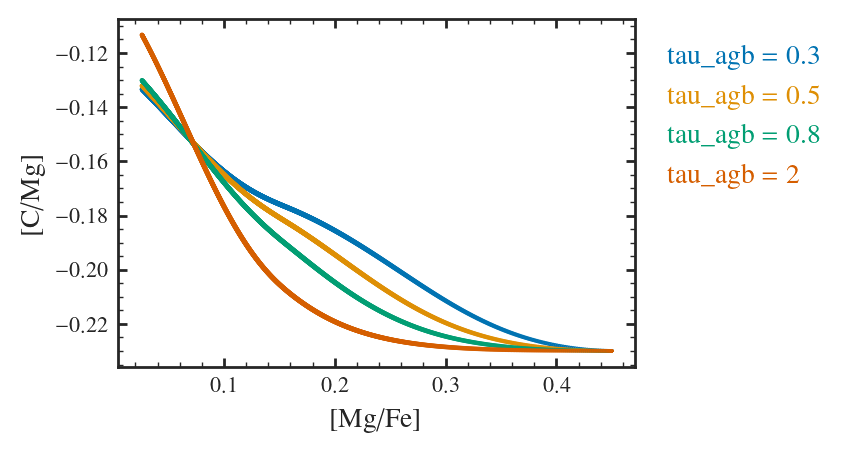

In [27]:
for model in [0.3, 0.5, 0.8, 2]:
    set_ana_yields(zeta=0, tau_agb=model)
    plot_sz(label=f"tau_agb = {model}")

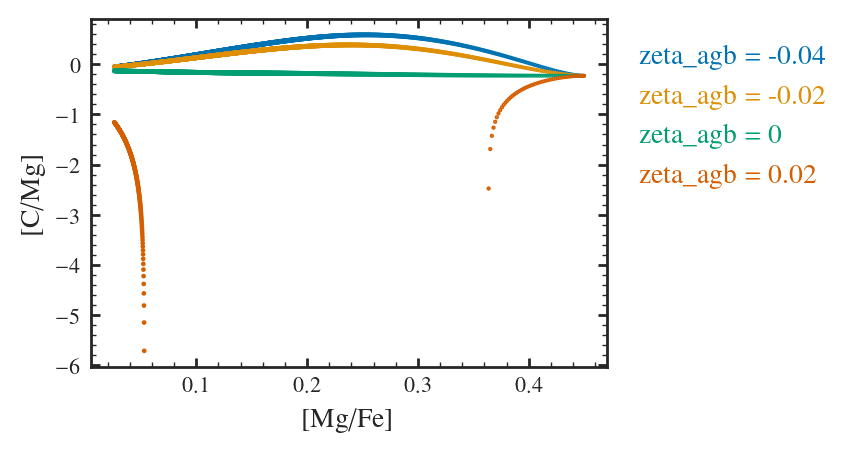

In [28]:
for model in [-0.04, -0.02, 0, 0.02]:
    set_ana_yields(zeta=model)
    plot_sz(label=f"zeta_agb = {model}")
    

## CCSNe

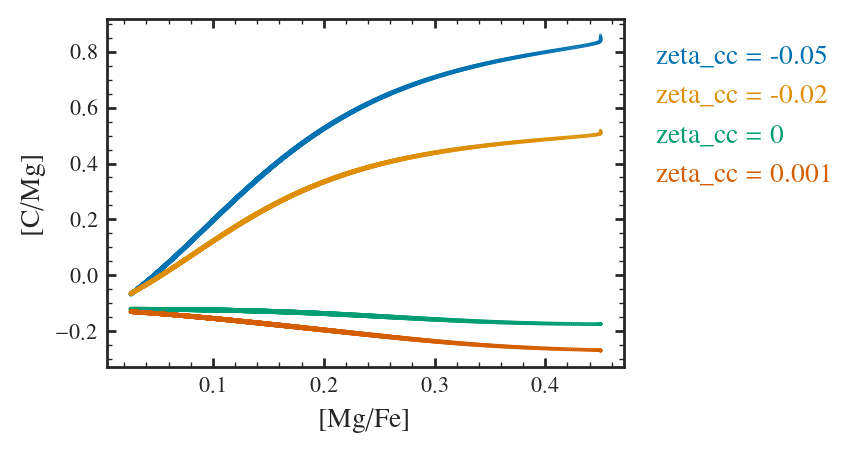

In [65]:
for model in [-0.05, -0.02, 0, 0.001]:
    make_yields(zeta_cc=model, agb_model="A", zeta_agb=0)
    plot_sz(label=f"zeta_cc = {model}")
    

In [35]:
make_yield_params(y_c_cc="BiLogLin")

YieldParams(yield_scale=1, mlr='larson1974', y_c_cc='BiLogLin', y0_c_cc=0.0022027168, zeta_c_cc=0.0019627619263157896, kwargs_c_cc={'y1': 0.0001}, Y_c_agb='cristallo11', alpha_c_agb=1.4491557894736842, kwargs_c_agb={'mass_factor': 1, 'no_negative': False, 'interp_kind': 'linear', 'low_z_flat': False}, y_c_ia=0, y0_n_cc=0.0005, zeta_n_cc=0, Y_n_agb='A', kwargs_n_agb={}, eta_n_agb=0.000502, y0_n_agb=0, y_fe_cc=0.000473, y_fe_ia=0.00077)

yields set to Magg et al. 2022 abundances
Yield settings
X        Z_solar    CC                             agb                            SN Ia                          

c        3.39e-03   2.20e-03 + 5.33e-02 (Z - Z0)   1.45 × cristallo11             0                              

n        1.04e-03   5.00e-04                       5.02e-04 M Z/Z0                0                              

o        7.33e-03   7.13e-03                       0                              0                              

mg       6.71e-04   6.52e-04                       0                              0                              

fe       1.37e-03   4.73e-04                       0                              7.70e-04                       



yields set to Magg et al. 2022 abundances
Yield settings
X        Z_solar    CC                             agb                            SN Ia                          

c        3.39e-03   2.20e-03 + 1.96e-03 [M/H]      1.45 × cristallo11          

(-1.0, 0.11670607843076473)

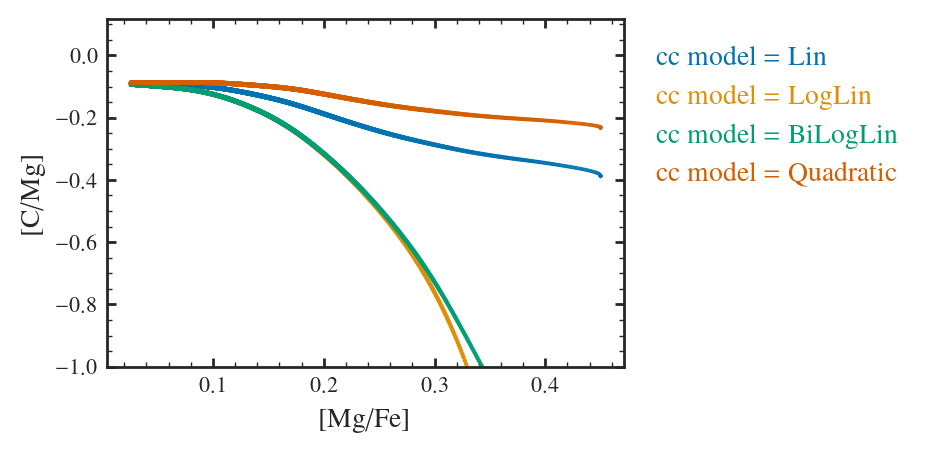

In [39]:
for model in ["Lin", "LogLin",  "BiLogLin", "Quadratic"]:
    make_yields(y_c_cc=model, verbose=True)
    plot_sz(label=f"cc model = {model}")

plt.ylim(-1)

## Iron

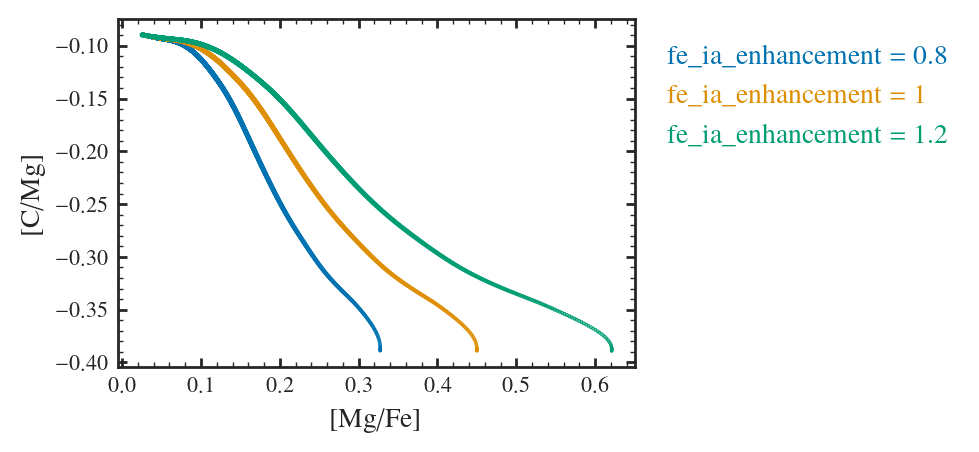

In [40]:
for model in [0.8, 1, 1.2]:
    make_yields(fe_ia_factor=model)
    plot_sz(label=f"fe_ia_enhancement = {model}")
    

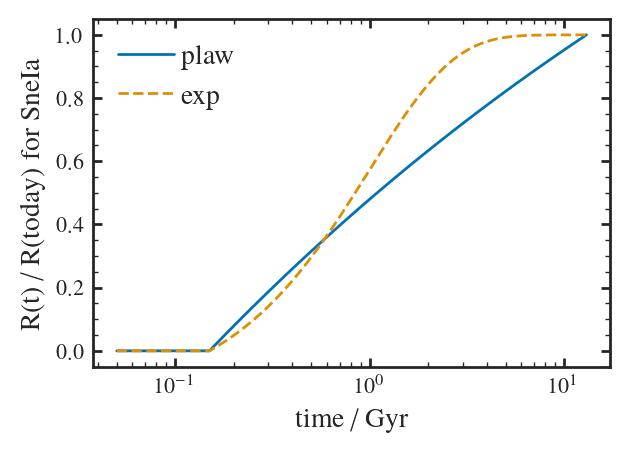

In [41]:
def dtd_1(t):
    return np.where(t > 0.15, t**(-1.1), 0)

def dtd_2(t):
    return np.where(t > 0.15, np.exp(-(t-0.15)), 0)

t = np.logspace(-1.3, np.log10(13), 1000)
dt = np.gradient(t)
R1 = np.cumsum(dtd_1(t)*dt)
R2 = np.cumsum(dtd_2(t)*dt)

plt.plot(t, R1 / R1[-1], label="plaw")
plt.plot(t, R2 / R2[-1], label="exp", ls="--")

plt.xscale("log")
plt.xlabel("time / Gyr")
plt.ylabel("R(t) / R(today) for SneIa ")
plt.legend()

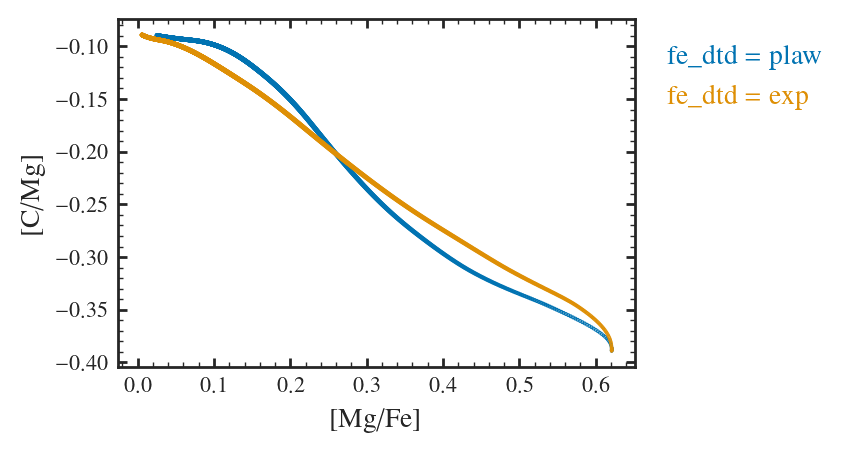

In [42]:
for model in ["plaw", "exp"]:
    plot_sz(label=f"fe_dtd = {model}", RIa=model)
    

## GCE Parameters

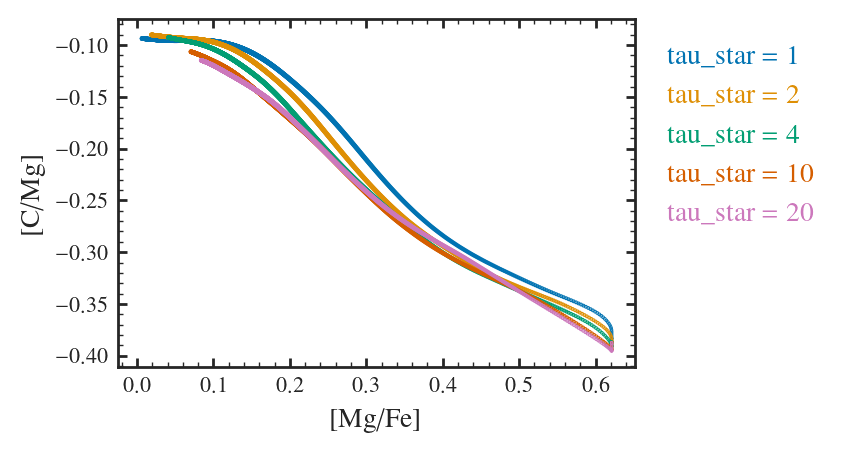

In [44]:
for model in [1, 2, 4, 10, 20]:
    plot_sz(label=f"tau_star = {model}", tau_star=model)
    

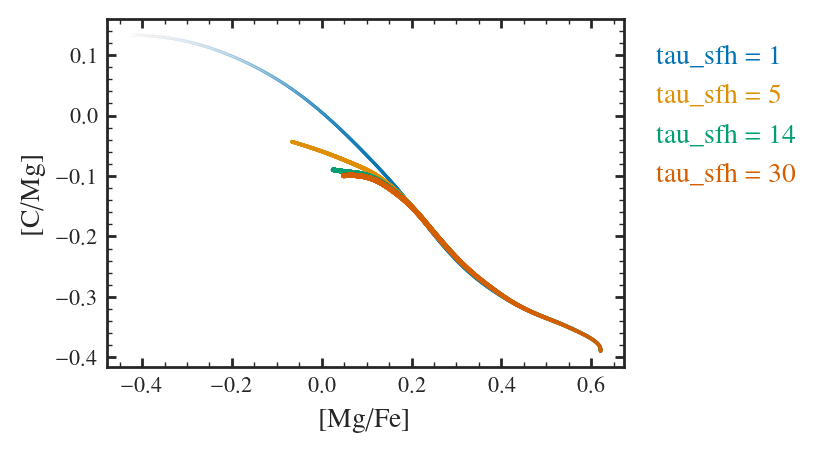

In [45]:
for model in [1, 5, 14, 30]:
    plot_sz(label=f"tau_sfh = {model}", tau_sfh=model)
    

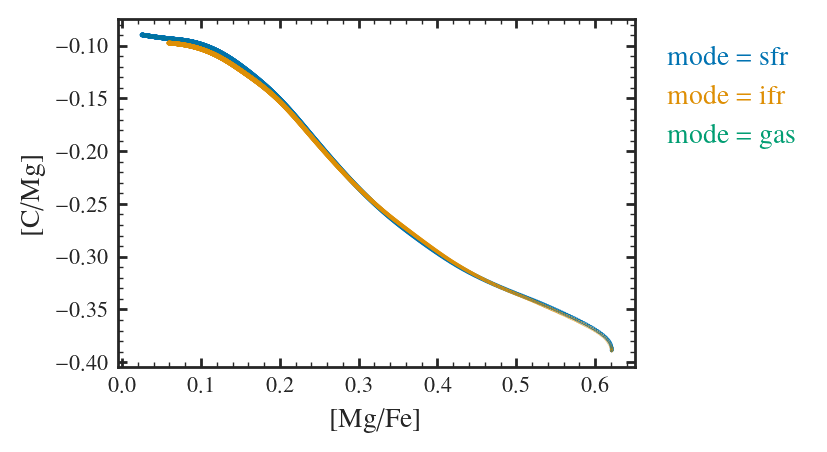

In [46]:
for model in ["sfr", "ifr", "gas"]:
    plot_sz(label=f"mode = {model}", mode=model)
    

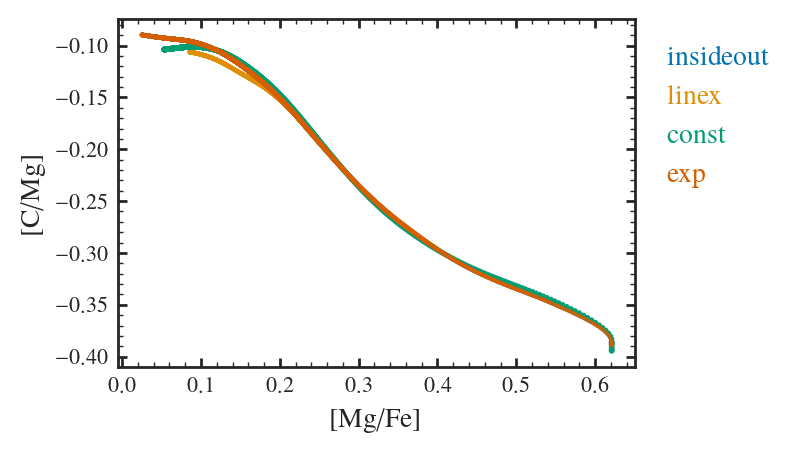

In [47]:
plot_sz(label=f"insideout", sfh=surp.simulation.sfh_models.insideout(tau_sfh=14))
plot_sz(label=f"linex", sfh=surp.simulation.sfh_models.linexp(tau_sfh=14))
plot_sz(label=f"const", sfh=lambda x: 1)
plot_sz(label="exp")


## Bimodality

In [48]:
t12 = 7

In [52]:
kwargs = dict()
sz1, h1 = run_singlezone(**kwargs)
sz2, h2 = run_singlezone(tau_sfh=3, tau_star=0.7, eta=0, t_end=t12, RIa="exp", **kwargs)

filt = np.array(h1["time"]) > t12 - 2
h1 = h1[filt]

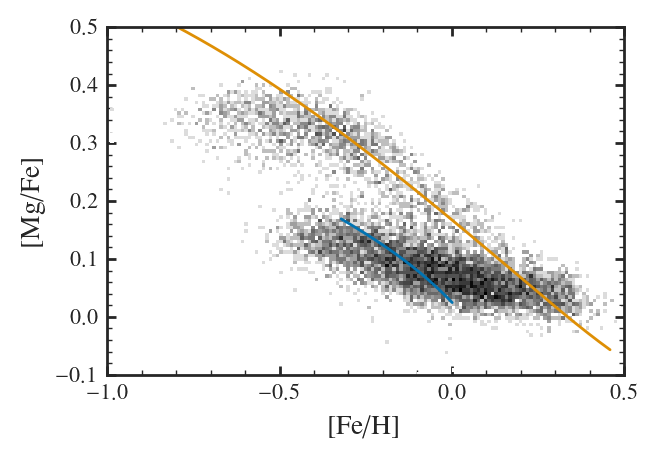

(-0.5, 0.1)

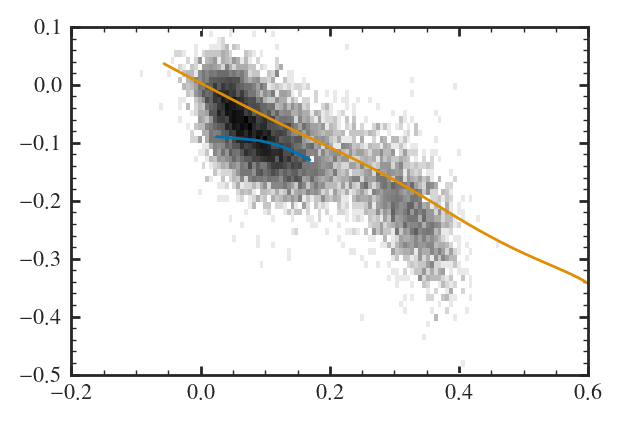

In [64]:

plt.plot(h1["[fe/h]"], h1.MG_FE)

plt.plot(h2["[fe/h]"], h2.MG_FE)

plt.hist2d(subgiants.FE_H, subgiants.MG_FE, 300, cmap="Greys", norm="log");
plt.xlim(-1, 0.5)
plt.ylim(-0.1, 0.5)
plt.xlabel("[Fe/H]")
plt.ylabel("[Mg/Fe]")
plt.show()


plt.plot(h1.MG_FE, h1.C_MG)
plt.plot(h2.MG_FE, h2.C_MG)
plt.hist2d(subgiants.MG_FE, subgiants.C_MG, 300, cmap="Greys", norm="log");
plt.xlim(-0.2, 0.6)
plt.ylim(-0.5, 0.1)